# Titanic Survival Prediction using ANN (Artificial Neural Network)


TensorFlow: 2.20.0

   Dataset loaded from: Titanic-Dataset.csv
   Dataset shape: (891, 12)
   Total passengers: 891
   Survivors: 342 (38.38%)
   Deaths: 549 (61.62%)

          Missing  Percentage
Age           177   19.865320
Cabin         687   77.104377
Embarked        2    0.224467

    Missing values filled
   Created 4 new features: FamilySize, IsAlone, Age_Group, Fare_Group
    Encoded Sex (female=0, male=1)
    Encoded Embarked (C=0, Q=1, S=2)
   Final feature count: 11

   Train set: 712 samples
   Test set: 179 samples

  Features standardized (mean=0, std=1)

   Total parameters: 12,417
   Architecture: 128 → 64 → 32 → 16 → 1
   Activation: ReLU (hidden), Sigmoid (output)
   Loss function: Binary Crossentropy

    Trained for 20 epochs
    Early stopping applied

    Trained for 20 epochs
    Early stopping applied

   Training Accuracy: 80.34%
   Test Accuracy: 78.77%

   Training Accuracy: 80.34%
   Test Accuracy: 78.77%

 ACCURACY CALCULATION DETAILS
Formula:
   Accurac

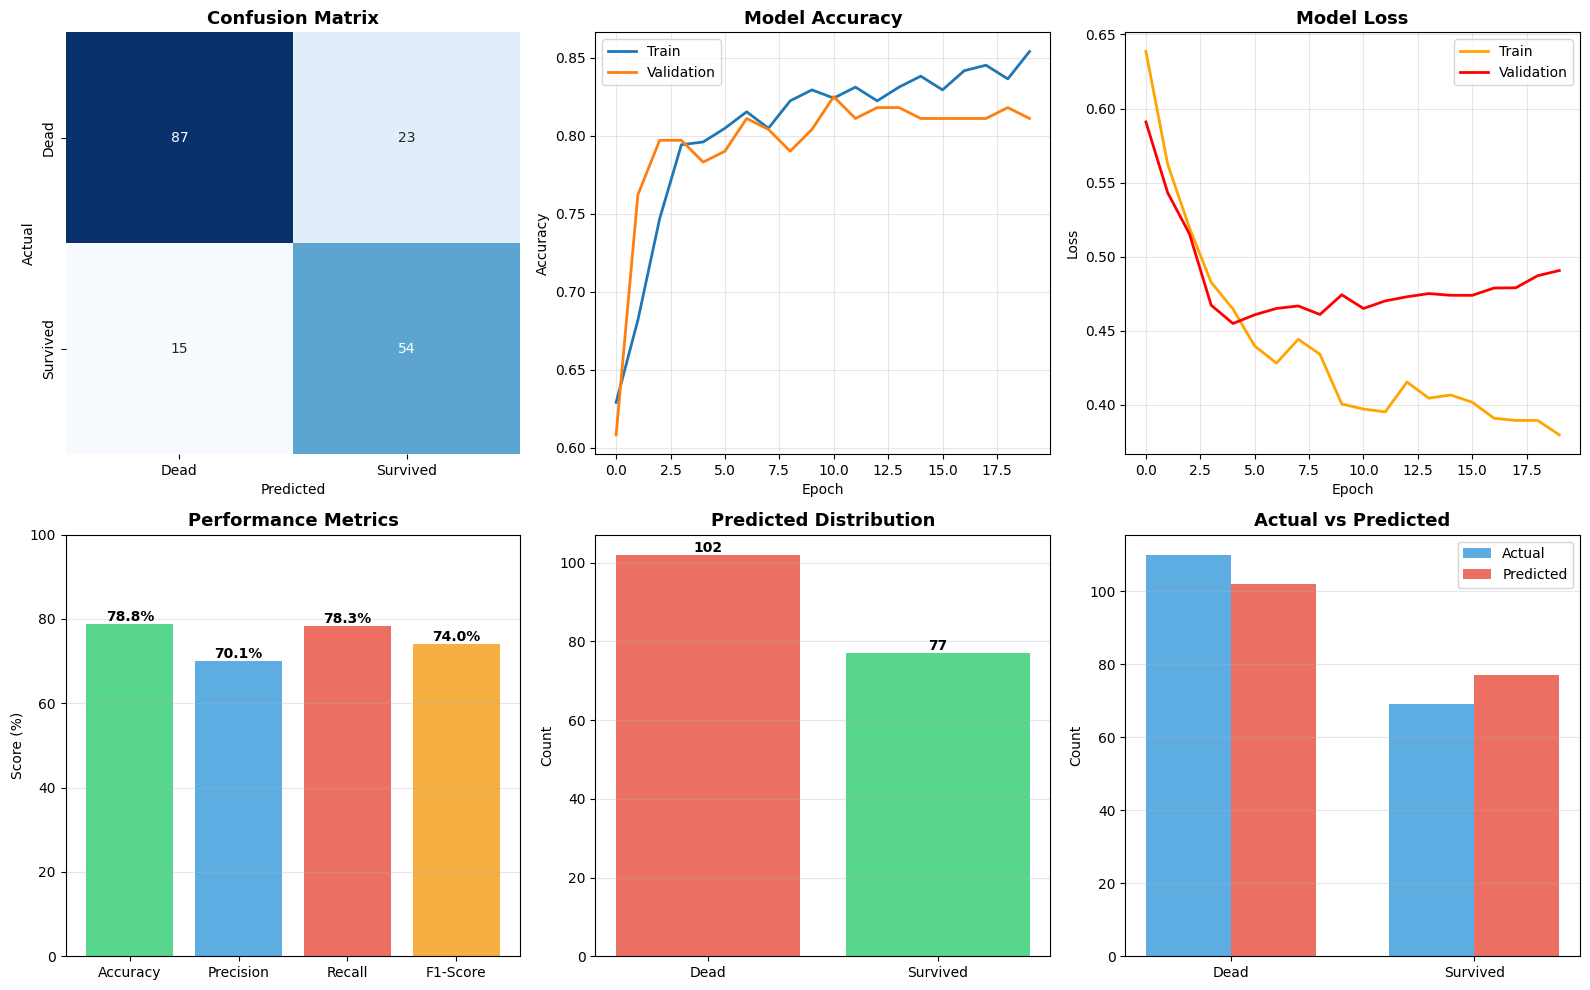

In [7]:
# Complete Titanic ANN Classification - All in One
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow: {tf.__version__}\n")

# STEP 1: Load Titanic Dataset

df = pd.read_csv('Titanic-Dataset.csv')
print(f"   Dataset loaded from: Titanic-Dataset.csv")
print(f"   Dataset shape: {df.shape}")
print(f"   Total passengers: {len(df)}")
print(f"   Survivors: {df['Survived'].sum()} ({df['Survived'].mean()*100:.2f}%)")
print(f"   Deaths: {(1-df['Survived']).sum()} ({(1-df['Survived'].mean())*100:.2f}%)\n")

# STEP 2: Exploratory Data Analysis
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing'] > 0])
print()

# STEP 3: Data Preprocessing
df_model = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']].copy()

# Handle missing values
df_model['Age'].fillna(df_model['Age'].median(), inplace=True)
df_model['Fare'].fillna(df_model['Fare'].median(), inplace=True)
df_model['Embarked'].fillna(df_model['Embarked'].mode()[0], inplace=True)
print(f"    Missing values filled")

# Feature Engineering
df_model['FamilySize'] = df_model['SibSp'] + df_model['Parch'] + 1
df_model['IsAlone'] = (df_model['FamilySize'] == 1).astype(int)
df_model['Age_Group'] = pd.cut(df_model['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[0, 1, 2, 3, 4])
df_model['Fare_Group'] = pd.qcut(df_model['Fare'], q=4, labels=[0, 1, 2, 3], duplicates='drop')
print(f"   Created 4 new features: FamilySize, IsAlone, Age_Group, Fare_Group")

# Encode categorical variables
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
df_model['Sex'] = le_sex.fit_transform(df_model['Sex'])
df_model['Embarked'] = le_embarked.fit_transform(df_model['Embarked'])
print(f"    Encoded Sex (female=0, male=1)")
print(f"    Encoded Embarked (C=0, Q=1, S=2)")

# Final features
feature_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 
                   'FamilySize', 'IsAlone', 'Age_Group', 'Fare_Group']
X = df_model[feature_columns].values
y = df_model['Survived'].values
print(f"   Final feature count: {X.shape[1]}\n")

# STEP 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"   Train set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples\n")

# STEP 5: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"  Features standardized (mean=0, std=1)\n")

# STEP 6: Build ANN Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(f"   Total parameters: {model.count_params():,}")
print(f"   Architecture: 128 → 64 → 32 → 16 → 1")
print(f"   Activation: ReLU (hidden), Sigmoid (output)")
print(f"   Loss function: Binary Crossentropy\n")

# STEP 7: Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=32, epochs=100, 
                    validation_split=0.2, callbacks=[early_stop], verbose=0)
print(f"    Trained for {len(history.history['loss'])} epochs")
print(f"    Early stopping applied\n")

# STEP 8: Evaluate Model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"   Training Accuracy: {train_acc*100:.2f}%")

# Test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"   Test Accuracy: {test_acc*100:.2f}%\n")

# Predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate detailed metrics
accuracy = accuracy_score(y_test, y_pred)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# STEP 9: Display Results
print(" ACCURACY CALCULATION DETAILS")

print("Formula:")
print("   Accuracy = (True Positives + True Negatives) / Total Predictions × 100")
print("   Accuracy = (Correct Predictions) / (Total Predictions) × 100\n")

print("\n CONFUSION MATRIX:")
print(f"   True Negatives (TN):  {tn:3d} - Correctly predicted deaths")
print(f"   False Positives (FP): {fp:3d} - Incorrectly predicted survivals")
print(f"   False Negatives (FN): {fn:3d} - Incorrectly predicted deaths")
print(f"   True Positives (TP):  {tp:3d} - Correctly predicted survivals\n")

print("\n ACCURACY CALCULATION:")
correct = tp + tn
total = tn + fp + fn + tp
print(f"   Correct Predictions = TP + TN = {tp} + {tn} = {correct}")
print(f"   Total Predictions = {total}")
print(f"   ")
print(f"   Accuracy = {correct}/{total} × 100")
print(f"   ACCURACY = {accuracy*100:.2f}%\n")

print("\n OTHER METRICS:")
print(f"   Precision: {precision*100:.2f}% - Of predicted survivors, how many actually survived")
print(f"   Recall (Sensitivity): {recall*100:.2f}% - Of actual survivors, how many we found")
print(f"   F1-Score: {f1_score*100:.2f}% - Harmonic mean of precision and recall")
print(f"   Specificity: {specificity*100:.2f}% - Of actual deaths, how many we found\n")

print(" FINAL RESULT")

print(f"   MODEL: Artificial Neural Network (ANN)")
print(f"   TEST ACCURACY: {accuracy*100:.2f}%")
print(f"   RATING: {'Excellent (>80%)' if accuracy > 0.80 else 'Good (>75%)' if accuracy > 0.75 else 'Fair'}")


# STEP 10: Visualizations
print("\nCreating visualizations")
plt.figure(figsize=(16, 10))

# Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Dead', 'Survived'], yticklabels=['Dead', 'Survived'])
plt.title('Confusion Matrix', fontweight='bold', fontsize=13)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Training History - Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Train', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.title('Model Accuracy', fontweight='bold', fontsize=13)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Training History - Loss
plt.subplot(2, 3, 3)
plt.plot(history.history['loss'], label='Train', linewidth=2, color='orange')
plt.plot(history.history['val_loss'], label='Validation', linewidth=2, color='red')
plt.title('Model Loss', fontweight='bold', fontsize=13)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Metrics Comparison
plt.subplot(2, 3, 4)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy*100, precision*100, recall*100, f1_score*100]
bars = plt.bar(metrics, values, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'], alpha=0.8)
plt.title('Performance Metrics', fontweight='bold', fontsize=13)
plt.ylabel('Score (%)')
plt.ylim([0, 100])
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f'{h:.1f}%', 
             ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Prediction Distribution
plt.subplot(2, 3, 5)
pred_dist = pd.Series(y_pred).value_counts().sort_index()
colors = ['#e74c3c', '#2ecc71']
bars = plt.bar(['Dead', 'Survived'], pred_dist.values, color=colors, alpha=0.8)
plt.title('Predicted Distribution', fontweight='bold', fontsize=13)
plt.ylabel('Count')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f'{int(h)}', 
             ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Actual vs Predicted
plt.subplot(2, 3, 6)
actual_dist = pd.Series(y_test).value_counts().sort_index()
x = np.arange(2)
width = 0.35
plt.bar(x - width/2, actual_dist.values, width, label='Actual', color='#3498db', alpha=0.8)
plt.bar(x + width/2, pred_dist.values, width, label='Predicted', color='#e74c3c', alpha=0.8)
plt.title('Actual vs Predicted', fontweight='bold', fontsize=13)
plt.ylabel('Count')
plt.xticks(x, ['Dead', 'Survived'])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [9]:
# FINAL SUMMARY
print("\nFINAL RESULTS\n")

print("MODEL: Artificial Neural Network (ANN)")
print(f"   Architecture: 128 → 64 → 32 → 16 → 1 neurons")
print(f"   Total Parameters: {model.count_params():,}")
print(f"   Activation Functions: ReLU + Sigmoid")
print(f"   Dropout Rates: 0.3, 0.3, 0.2")

print("\nDATASET: Titanic")
print(f"   Total Passengers: 891")
print(f"   Training Samples: {len(X_train)}")
print(f"   Test Samples: {len(X_test)}")
print(f"   Features Used: 11")

print("\nPERFORMANCE:")
print(f"   TEST ACCURACY: {accuracy*100:.2f}%")
print(f"   Precision: {precision*100:.2f}%")
print(f"   Recall: {recall*100:.2f}%")
print(f"   F1-Score: {f1_score*100:.2f}%")

print("\nCONFUSION MATRIX:")
print(f"   True Positives: {tp}")
print(f"   True Negatives: {tn}")
print(f"   False Positives: {fp}")
print(f"   False Negatives: {fn}")

print(f"\nRating: {'Excellent (>80%)' if accuracy > 0.80 else 'Good (>75%)' if accuracy > 0.75 else 'Fair'}\n")


FINAL RESULTS

MODEL: Artificial Neural Network (ANN)
   Architecture: 128 → 64 → 32 → 16 → 1 neurons
   Total Parameters: 12,417
   Activation Functions: ReLU + Sigmoid
   Dropout Rates: 0.3, 0.3, 0.2

DATASET: Titanic
   Total Passengers: 891
   Training Samples: 712
   Test Samples: 179
   Features Used: 11

PERFORMANCE:
   TEST ACCURACY: 78.77%
   Precision: 70.13%
   Recall: 78.26%
   F1-Score: 73.97%

CONFUSION MATRIX:
   True Positives: 54
   True Negatives: 87
   False Positives: 23
   False Negatives: 15

Rating: Good (>75%)

